## Task 3:Mean-shift and CAM-shift

Import necessary Libraries

In [ ]:
#Use Javascript code to call your local webcam
from IPython.display import display, Javascript
from google.colab.output import eval_js
#Convert the image type that captured by webcam
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image

import io
# OpenCV library 
import cv2 
# plot the img 
from google.colab.patches import cv2_imshow

In [ ]:
# Check opencv Library version
cv2.__version__

'4.1.2'

JavaScript Code to call local WebCam and the returned image type is base64



In [ ]:
from google.colab.output import eval_js

def VideoCapture():
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

### Define the Image Conversion function

For VideoCapture functions return images with base64 type

For cv2 need images with bytes type

In [ ]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

The haar cascades files are in Google drive

In [ ]:
 # Load cascades using v2.CascadeClassifier
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load cascades using cv2.CascadeClassifier
faces_cascades = cv2.CascadeClassifier("/content/drive/MyDrive/Computer_Vision/haarcascade_frontalface_default.xml")

Show the image histogram

In [ ]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

Detect Faces

In [ ]:
def detect_faces(img, cascades):
  #transform image into grayscale
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  #use cascades to detect faces
  faces = cascades.detectMultiScale(gray)
  return faces

### Capture the face

In [ ]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")
  # Take a capture 
  byte = eval_js('capture()')
  # Convert the capture from base64 to bytes array
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  # Using cascades to detect faces
  faces = detect_faces(im, faces_cascades)

  #yprint(len(faces))
  if len(faces) == 1:
    face = faces[0]
    # draw a green rectangle around the face
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue

  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  if response == 'y':
    # frame contains the face region # grayscale picture
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    # plot the frame
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    tracking_window = face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:ok
1
Use this bounding box? [y or n]:y


In [ ]:
# here the webcam is RGB mode, but cv2 using BGR mode
cv2_imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
# another way to change the color mode
r,g,b = cv2.split(frame)
frame_change_order = cv2.merge([b,g,r])
cv2_imshow(frame_change_order)
#frame = frame_change_order

Transform face into histogram

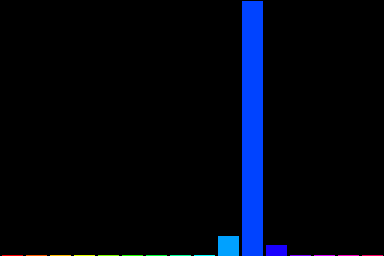

In [ ]:
# Transform the frame into HSV space
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

# Create an inRange mask for pixels. Limit the saturation in [64., 255.] and brightness in [32., 200.]
# only contains white and black color
mask = cv2.inRange(frame_hsv, np.array((0., 64., 32.)), np.array((180., 255., 200.)))

# Compute the histogram of the frame (use only the HUE channel). See `https://bit.ly/3pdVUEd`
# Take into account only pixels which are not too bright and not too dark (use the previous mask)
# Use 16 bins and speicfy the range of the hue ([0, 180])
frame_hist = cv2.calcHist([frame_hsv], [0], mask, [16], [0,180])

# Normalize the histogram between 0 (lowest intensity) and 255 (highest intensity) (use MinMax normalization `cv.NORM_MINMAX`) using the method `https://bit.ly/3jMGhCj`
frame_hist = cv2.normalize(frame_hist, 0, 255, cv2.NORM_MINMAX)

# Reashape the histogram into a 1-D array (use `.reshape(-1)`)
frame_hist = frame_hist.reshape(-1)

# Show the histogram
show_hist(frame_hist)

### Mean-shift

In [ ]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
# stop when the next center is very close
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  # Take a capture
  byte = eval_js('capture()') 
  # transform the frame type b64 into byte
  im = b64_to_bytes(byte)

  # Convert the capture to HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Compute an inRange mask  as before with the frame
  mask = cv2.inRange(hsv, np.array((0., 64., 32.)), np.array((180., 255., 200.)))
  
  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([hsv], [0], frame_hist, [0,180], scale = 1)
  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  prob = prob & mask

  #_, tracking_window = cv2.meanShift('''back_projection here''', tracking_window '''This has been first computed in the beginning''', term_crit)
  _, tracking_window = cv2.meanShift(prob, tracking_window, term_crit)
  (x, y, w, h) = tracking_window
  
  # plot a bounding box with coordiantes `tracking_window` in the image
  cv2.rectangle(im, (x,y), (x+w, y+h), (255, 0, 0), 2)
  
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))
  #eval_js('showimg("{}")'.format(bytes_to_b64(im)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

### Cam-shift

In [ ]:
VideoCapture()
eval_js('create()')

# These mean: Stop the mean-shift algorithm iff we effectuated 10 iterations or the computed mean does not change by more than 1pt ~ 1.3px in both directions
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
  # Take a capture
  byte = eval_js('capture()') 
  # Convert the capture type b64 to bytes
  im = b64_to_bytes(byte)

  # Convert the capture to HSV
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # Compute an inRange mask  as before with the frame
  mask = cv2.inRange(hsv, np.array((0., 64., 32.)), np.array((180., 255., 200.)))

  # Back project the frame histogram into the hsv image. Use only channel 0 (Hue), range of [0,180] and scale of 1
  prob = cv2.calcBackProject([hsv], [0], frame_hist, [0,180], scale = 1)
  # Bitwise and the back projection and the previously computed mask in order to remove very bright or very dark pixels (you can use `&` of python or cv2.bitwise_and in opencv)
  prob = prob & mask

  #bbox, tracking_window = cv2.CamShift('''back_projection here''', tracking_window '''This has been first computed in the beginning''', term_crit)
  bbox, tracking_window = cv2.CamShift(prob, tracking_window , term_crit)

  # Array of polygonal curves.
  pts = cv2.boxPoints(bbox).astype(np.int)
  # cv2.polylines() method is used to draw a polygon on any image.
  cv2.polylines(im, [pts], True, (255, 0 , 0), 2)
  eval_js('showimg("{}")'.format(bytes_to_b64(im)))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored